# Classification task on PLUTO (New York City Primary Land Use Tax Lot Output) Dataset

Scikit learn, pandas and matplotlib packages of python were chosen. These packages provide various utilities that make preprocessing datasets and training machine learning algorithms much more easier. The preprocessing steps, classification choices, cross validation and hyper-parameter tuning steps are explained in detail. Some sections can be skipped when reproducing results. 


In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score  
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve,f1_score,average_precision_score,auc
from sklearn.model_selection import GridSearchCV

RANDOM_SEED=42
#Read the training and test datasets
trainData='train.csv'
testData='test.csv'

train=pd.read_csv(trainData,header=0).drop(columns='index')
test=pd.read_csv(testData,header=0).drop(columns='index')
trainSize=len(train)
testSize=len(test)

## Preprocessing Data Column-wise

When the data is inspected it can be seen that there are a lot of missing values. Hence, the columns that contain a great portion of missing values are eliminated according to a certain threshold. The threshold is selected emprically as 50 percent after inspecting the columns that have missing values from the data dictionary. In this case, %50 threshold gave reasonable results when the trained model was validated. However, in some cases even columns that have much higher amount of missing values might be valuable in the classification task but in this case the approach was sufficient. Importantly, both the train and test set seems to come from the same distribution and the columns to be dropped are identical so dropping them won't cause a problem on the test data.

In [6]:
#Print the percentage of NaNs that each column has in training data for analysis
print(train.isnull().sum(axis=0)/len(train))

#Define a threshold for dropping the columns with NaN percent above a certain threshold
threshold=0.5

#Drop the columns exceeding the threshold both on training and test data
trainColumnsDrop=train.columns[train.isnull().sum(axis=0)/len(train)>threshold]
testColumnsDrop=test.columns[test.isnull().sum(axis=0)/len(test)>threshold]

print("The columns to be dropped from train and test data are the same: ", pd.Index.equals(trainColumnsDrop,testColumnsDrop))

train=train.drop(trainColumnsDrop,axis=1)
test=test.drop(testColumnsDrop,axis=1)

print("Train data size: ",trainSize)
print("Test data size: ",testSize)
print("Number of columns dropped: ",len(trainColumnsDrop))

borough                 0.000000
block                   0.000000
lot                     0.000000
schooldist              0.003205
council                 0.003516
zipcode                 0.004840
firecomp                0.004079
policeprct              0.003451
healthcenterdistrict    0.003093
healtharea              0.003854
sanitboro               0.007409
sanitdistrict           0.007369
sanitsub                0.018478
zonedist1               0.001173
zonedist2               0.976886
zonedist3               0.999783
zonedist4               0.999984
overlay1                0.912974
overlay2                0.999818
spdist1                 0.881404
spdist2                 0.999921
spdist3                 1.000000
ltdheight               0.996481
splitzone               0.001173
landuse                 0.003336
easements               0.000000
lotarea                 0.000000
bldgarea                0.000000
comarea                 0.000000
resarea                 0.000000
          

## Preprocessing the NaN values

Dropping the columns with high amount of NaN values is not enough and further preprocessing is needed. There are still some amount of missing values left in the data. After, inspecting the data dictionary I found it not very reasonable to fill the missing data according to mean values in the column or by just replacing with the most occuring values. Instead, the numeric columns were filled with -1 (Not within range of any column values) or as "MISSING" for string valued columns. Providing the classifier with missing information might even be better in terms training the model since missing information is also valuable when compared to dropping all the values. Importantly, dropping the rows that contained NaN values was also tried but resulted in a great amount of elimination of training data. Hence, instead of dropping NaN, they were filled as missing. 


In [7]:
#Find numeric and categorical columns
float_cols_tr = train.select_dtypes(include=['float64','int64']).columns
str_cols_tr = train.select_dtypes(include=['object']).columns
float_cols_test = test.select_dtypes(include=['float64','int64']).columns
str_cols_test = test.select_dtypes(include=['object']).columns

#fill the numeric columns with -1 and categorical columns with 'MISSING'
train.loc[:, float_cols_tr]=train.loc[:, float_cols_tr].fillna(-1)
train.loc[:, str_cols_tr]=train.loc[:, str_cols_tr].fillna('MISSING')
test.loc[:, float_cols_test]=test.loc[:, float_cols_test].fillna(-1)
test.loc[:, str_cols_test]=test.loc[:, str_cols_test].fillna('MISSING')

## Encoding the values in the dataset

Since categorical data is not allowed by most of the classifiers the data is transformed by encoding the labels. Scikit learn only accepts data in numeric format, therefore a very handy utility called LabelEncoder was used. After the encoding operation, training feature and the target value was seperated. 

In [8]:
#Transform the data to a format compatible with scikitlearn. Employ label encoding on each column
le=LabelEncoder()
train.loc[:, str_cols_tr]=train.loc[:, str_cols_tr].apply(le.fit_transform)
test.loc[:, str_cols_test]=test.loc[:, str_cols_test].apply(le.fit_transform)

#Seperate each the features from the target class
trainX,trainY=train.iloc[:,:-1],train.iloc[:,-1]

trainX.head(10)

,borough,block,lot,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,...,exemptland,exempttot,yearbuilt,yearalter1,yearalter2,builtfar,tract2010,xcoord,ycoord,zonemap
0,1,3717,64,8.0,18.0,10472.0,69,43.0,26.0,3020.0,...,0,0,1940,0,0,0.62,48,1018914.0,239801.0,113
1,3,15818,48,27.0,31.0,11691.0,139,101.0,45.0,3800.0,...,0,0,1930,0,0,0.48,99802,1051073.0,155952.0,88
2,0,6787,7,22.0,48.0,11229.0,147,61.0,35.0,7320.0,...,1470,1470,1930,0,0,0.69,548,998378.0,161944.0,57
3,0,672,30,15.0,38.0,11232.0,108,72.0,39.0,4400.0,...,0,0,1910,0,0,1.24,101,983777.0,178952.0,25
4,0,6651,7501,21.0,44.0,11223.0,195,62.0,37.0,8522.0,...,0,356862,2002,0,0,3.59,426,990141.0,159965.0,55
5,3,1583,151,24.0,25.0,11373.0,158,110.0,42.0,1420.0,...,0,0,1968,0,0,1.52,471,1018443.0,209795.0,128
6,3,8538,9,26.0,23.0,11040.0,129,105.0,43.0,2170.0,...,1470,1470,1950,0,0,0.29,155102,1064643.0,212705.0,7
7,0,7427,41,22.0,48.0,11235.0,188,61.0,37.0,8900.0,...,0,0,1955,0,0,1.22,626,1002246.0,155099.0,78
8,1,5521,85,8.0,13.0,10465.0,50,45.0,26.0,3220.0,...,0,0,1930,0,0,0.41,118,1037553.0,236606.0,117
9,1,5767,791,10.0,11.0,10463.0,243,50.0,21.0,200.0,...,0,0,1940,0,0,0.88,285,1011053.0,261816.0,43


## Class Imbalance
The most important issue for this dataset is the class imbalance problem. It is easily seen that the majority of the instances in the training set contain a great deal of negative class labels where as the number of positive labels are extremely low. The percentage of negative labels are almost %99.2 where as positive labels are almost %0.8.

In [13]:
#Imbalanced dataset
print(trainY.value_counts())
print()
print("Negative Class Percentage: ",trainY.value_counts()[0]/trainY.value_counts().sum()*100)
print("Positive Class Percentage: ",trainY.value_counts()[1]/trainY.value_counts().sum()*100)

False    681787
True       5582
Name: target__office, dtype: int64

Negative Class Percentage:  99.18791798873676
Positive Class Percentage:  0.8120820112632371


## PCA to see which features explains the variance most ?
Principal Component Analysis (PCA) is a very useful tool commonly used to interpret the amount of variance a feature explains in the dataset. It is also commonly used in dimentionality reduction in the case of too many features and to be able to plot such data. In this case, features were mostly categorical therefore applying PCA would not make much sense. I wanted to see if anything meaningful will be obtained after normalizing the data. In this case, most of the features contribute to the variance and the first 10 features explain around %50 of the variance in the data. 

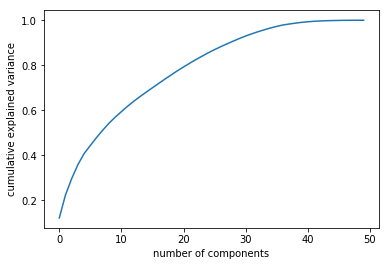

In [10]:
transformedData = StandardScaler().fit_transform(trainX)
pca = PCA().fit(transformedData);
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Training models and checking overfitting and underfitting

#### NOTE: This part of the notebook can be skipped when producing the results since it is mostly about figuring out if overfitting occurs or not based on stratified K-fold cross validation !

Since the dataset suffers from class imbalance it is useful to employ a classification algorithm that tend to solve this problem to an extent. Random forests is a good option because of bagging and the data won't need much normalization and it tends to do better on imbalaced datasets since it is more robust with decision boundaries. However, other classifiers like weighted linear SVM, naive bayes classifier, stochastic gradient descent classifier and ada boost with decision tree as its classifier were tried. Experiments with these classfiers are commented out since it was decided to proceed with random forest classifier due to better results and efficiency.

First experiments were made using the heldout approach where 30 percent of the training data was selected as validation set. Stratified selection was utilized to eliminate any problems due to class imbalance problem. Then, Stratified 3-fold cross validation was applied to see whether our model overfits the data or not. According to the results the model is succesfull on all folds and performs similary hence it seems to fit the data well. 

Furthermore, the evaluation metric is also a very important factor with datasets that have class imbalance problem. For instance, accuracy measure is misleading since the majority of the class belongs to negative class and would dominate the accuracy measure. Therefore, several approaches were used to successfully measure the performance. A confusion matrix with precision recall and f1 score was utilized. Precision and recall are imoprtant since these are based on positive class. Another metric was precision recall curve which is preferred in datasets that are imbalanced. 

A custom scorer function was implemented to incorporate these metrics in the evaluation step of the models.



In [7]:
def custom_scorer(estimator,X,y):
    print(estimator)
    yPred=estimator.predict(X)
    yProbs=estimator.predict_proba(X)[:,1]
   
    accuracy=accuracy_score(y,yPred)
    precision, recall, thresholds = precision_recall_curve(y, yProbs)
    f1 = f1_score(y, yPred)
    auc_score = auc(recall, precision)
    ap = average_precision_score(y, yProbs)
    print(classification_report(y,yPred))
    print('F1-measure=%.3f AUC=%.3f Average Precision=%.3f' % (f1, auc_score, ap))
    
    return f1



####################### HELDOUT Random Forest #############################
#Stratified sampling is done since the dataset is imbalanced
X,valX,y,valY=train_test_split(trainX,trainY,test_size=0.3,random_state=RANDOM_SEED)

model=RandomForestClassifier(n_estimators=100,max_depth=50,random_state=RANDOM_SEED)
model.fit(X,y)
custom_scorer(model,valX,valY)

#Linear SVM with class weighting
#svm = SVC(kernel='linear', class_weight='balanced', probability=True) 
#svm.fit(X, y)

#Naive Bayes Classifier
#gnb = GaussianNB()
#gnb.fit(X,y)
#custom_scorer(gnb,valX,valY)

#Stochastic Gradient Descent Classifier with log loss in order get probabiility based results
#clf = SGDClassifier(loss='log')
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)
#clf.fit(X,y)
#valX = scaler.transform(valX)
#custom_scorer(clf,valX,valY)

#Ada Boost Classsifier with decision trees as classifier
#abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
#abc.fit(X,y)
#custom_scorer(abc,valX,valY)

####################### Stratified K-Fold Random Forest #############################
#To make sure not to overfit data utilize k-fold evaluation 

results = cross_val_score(estimator=model, X=trainX, y=trainY, cv=3,scoring=custom_scorer,verbose=10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    204600
        True       0.97      0.91      0.94      1611

   micro avg       1.00      1.00      1.00    206211
   macro avg       0.98      0.95      0.97    206211
weighted avg       1.00      1.00      1.00    206211

F1-measure=0.937 AUC=0.975 Average Precision=0.974
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    227263
        True       0.96      0.90      0.93      1861

   micro avg       1.00      1.00      1.00    229124
   macro avg       0.98      0.95      0.96    229124
weighted avg       1.00      1.00      1.00    229124

F1-measure=0.929 AUC=0.971 Average Precision=0.970
[CV] ....................... , score=0.9286705523175133, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    227262
        True       0.96      0.90      0.93      1861

   micro avg       1.00      1.00      1.00    229123
   macro avg       0.98      0.95      0.97    229123
weighted avg       1.00      1.00      1.00    229123

F1-measure=0.931 AUC=0.974 Average Precision=0.973
[CV] ....................... , score=0.9307371349095966, total= 1.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    227262
        True       0.96      0.90      0.93      1860

   micro avg       1.00      1.00      1.00    229122
   macro avg       0.98      0.95      0.97    229122
weighted avg       1.00      1.00      1.00    229122

F1-measure=0.933 AUC=0.973 Average Precision=0.972
[CV] ....................... , score=0.9328896283971159, total= 1.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min finished


## Hyperparameter Optimization

#### NOTE: This part of the notebook can be skipped when producing the results since it is mostly about finding the best parameters for the final model !

Classifiers usually have various hyperparameters which also effect the performance of the model. These parameters need to be finetuned to come up with a model that performs better than the others. Therefore, a hyperparmeter optimization was done in order to find the best parameters using grid search. The parameter grid was constructed empirically with values that are usually considered to be more important in random forests. Although, there are many hyperparameters such as min sample in leaf, max features, max depth, number of models, splitting criterion and so on. Only, n_estimators and max_depth were considered due to computational time. The best parameters in the end were; num_estimators=200 and max_depth=50.

In [8]:
####################### Grid Search for Random Forest classifier ###################
param_grid = { 
    'n_estimators': [50,100,200],
    'max_depth':[50,100,150]
#    'criterion': ['gini','entropy']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv= 3,scoring='f1', verbose=20,n_jobs=-1)
grid_search.fit(trainX, trainY)
print(grid_search.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done   2 out of  27 | elapsed:   53.2s remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   4 out of  27 | elapsed:   54.5s remaining:  5.2min
[Parallel(n_jobs=-1)]: Done   6 out of  27 | elapsed:   55.9s remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   8 out of  27 | elapsed:  1.1min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  27 | elapsed:  1.7min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  27 | elapsed:  1.8min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  14 out of  27 | elapsed:  1.8min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  16 out of  27 | elapsed:  1.8min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  2.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:  3.3min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  22 out of  27 | elapse

{'n_estimators': 200, 'max_depth': 50}


## Training the final model

Now that the best parameters for the model have been found with grid search, the final model can be trained on the whole training data. Then the test set can be used to make the predictions.

In [11]:
#Predict actual test set and sace data
model=RandomForestClassifier(n_estimators=200,max_depth=50,n_jobs=-1,random_state=RANDOM_SEED)
model.fit(trainX,trainY)
yPredTest=model.predict(test)

## Append the predictions to the test file

In [12]:
#Create a new column for predictions
pred_column=pd.Series(data=yPredTest)
print("See if the predictions are dominated by negative class")
print(pred_column.value_counts())

pred_column.replace({0: "FALSE", 1: "TRUE"},inplace=True)

#Read the test file again, append the prediction column and save it
df = pd.read_csv(testData)
df['predicted_office'] = pred_column 
df.to_csv(testData,index=False)

See if the predictions are dominated by negative class
False    170542
True       1301
dtype: int64
